# Image Caption Generator using CNN(Xception) and LSTM



## Introduction

You saw an image and your brain can easily tell what the image is about, but can a computer tell what the image is representing? Computer vision researchers worked on this a lot and they considered it impossible until now! With the advancement in Deep learning techniques, availability of huge datasets and computer power, we can build models that can generate captions for an image.


This is what we are going to implement in this Python based project where we will use deep learning techniques of Convolutional Neural Networks **(CNN)** and a type of Recurrent Neural Network **(LSTM)** together.

## Goal

The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.

## What is Image Caption Generator?

Image caption generator is a task that involves computer vision and natural language processing concepts to recognize the context of an image and describe them in a natural language like English.Its the task of predicting a caption for a given image.

## What is CNN?

CNN is a subfield of Deep learning and specialized deep neural networks used to recognize and classify images. It processes the data represented as 2D matrix-like images. CNN can deal with scaled, translated, and rotated imagery. It analyzes the visual imagery by scanning them from left to right and top to bottom and extracting relevant features. Finally, it combines all the parts for image classification.

## What is Xception?

`Xception` : Short for `Extreme Inception` , builds in the Inception architecture but we replace the `Standard Convolution` by the `Depthwise Seperable Convolution` (which improve efficiency and performance by reducing the number of parameters and computional cost)

*Depthwise Convolution* : 
- Applies a seperate filter to each channel of the input feature map .
- Capture spatial info within each channel independently , without mixing info .

*Pointwise Convolution* : 
- Follows depthwise convolution using 1*1 filters to combine across channels .
- Mixing spetial info from different channels . 

Xception was trained on an imagenet dataset with 1000 different classes to classify the images. We can use keras.applications to import this model directly.

### What is LSTM?

Being a type of RNN (recurrent neural network), LSTM (Long short-term memory) is capable of working with sequence prediction problems. It is mostly used for the next word prediction purposes, as in Google search our system is showing the next word based on the previous text. Throughout the processing of inputs, LSTM is used to carry out the relevant information and to discard non-relevant information.

### Our Architecture?

![title](Architecture.jpeg)

### Process


- We use pre-trained CNN models like Xception to extract features from the images.
- These extracted features are passed through a linear layer and then fed into an LSTM network.
- The LSTM network generates captions by predicting the next word in the sequence until it reaches the end token.

## Dataset for Image Caption Generator

For the image caption generator, we will be using the Flickr_8K dataset. There are also other big datasets like Flickr_30K and MSCOCO dataset but it can take weeks just to train the network so we will be using a small Flickr8k dataset. The advantage of a huge dataset is that we can build better models.

The most important file is **Flickr 8k.token**, which stores all the image names with captions. 8091 images are stored inside the Flicker8k_Dataset folder and the text files with captions of images are stored in the Flickr_8k_text folder.

## Image caption generator in code

install the required libraries: 

## import all the necessary packages

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
import os
import string
import keras
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input # pour preparer les images a notre model
from keras.preprocessing.image import load_img # Image preprocessing
from keras.preprocessing.image import img_to_array # 
from tensorflow.keras.preprocessing.text import Tokenizer # text tokenization
from keras.preprocessing.sequence import pad_sequences # sequence preparation 
from keras.utils import to_categorical # one hot encoding 
from tensorflow.keras.layers import add # layer addition 
from keras.models import Model, load_model # loading the model 
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout #Network layers 
from tqdm import tqdm_notebook as tqdm #to check loop progress
from tqdm import tqdm

tqdm().pandas()


0it [00:00, ?it/s]


## Getting and performing data cleaning

In [5]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

Load the document file and read the content of the file into a string

In [6]:
# Obtain captions of all images
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

Used to create a dictionary that will map images with all captions.

In [7]:
# Data cleaning: lowercasing & removing puntuations/words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):

            img_caption.replace('-',' ')
            desc = img_caption.split()

            # Lowercasing
            desc = [word.lower() for word in desc]
            # Removing punctuation from each token
            desc = [word.translate(table) for word in desc]
            # Removing hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            # Removing tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            # Converting back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

Used to clean the data by taking all description as input , it normalize them by converting them to lower case, removing punctuation, and removing short words and numbers.

In [8]:
# Build vocabulary of all unique words
def text_vocabulary(descriptions):
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

Used to build vocabulary of unique words from all captions.

In [9]:
# All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = '\n'.join(lines)
    file = open(filename,'w')
    file.write(data)
    file.close()

Save all prepocessed images into a file.

In [10]:
dataset_text = "C:/Users/info/Downloads/Flickr8k_text"
dataset_images = "C:/Users/info/Downloads/Flickr8k_Dataset/Flicker8k_Dataset"

In [11]:
# Prepare our text data
filename = dataset_text + "/" + "flickr8k.token.txt"
# Load the file that contains all data
# Map them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

# Clean the descriptions
clean_descriptions = cleaning_text(descriptions)

# Building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

# saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


## Extracting the feature vector from all images (TAKES TIME)

In [34]:
def extract_features(directory):
        model = Xception(include_top=False, pooling='avg')
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = cv2.imread(filename, -1)
            image = cv2.resize(image, (299, 299))
            # for images that has 4 channels, we convert them into 3 channels
            if image.shape[2] == 4:
                image = image[..., :3]
            image = np.expand_dims(image, axis=0)
#             image = preprocess_input(image)
            image = image / 127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

We use a pre-trained Xception model for feature extraction, but it requires images of a specific size. To meet this requirement, we resize and preprocess our images. Then, we remove the model's classification layer to extract 2048-dimensional feature vectors. We store these vectors in a dictionary and save them to a file named "features.p".

In [13]:

# To directly load the features from the pickle file.
features = load(open("features.p","rb"))

## Loading dataset for Training the model

In [14]:
# Load the image data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

Return the list of image names.

In [15]:
# Load clean_descriptions
def load_clean_descriptions(filename, photos):   
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

Stores the captions for every image from the list of photos to a dictionary. For the ease of the LSTM model in identifying the beginning and ending of a caption, we append the and identifier with each caption.

In [16]:
# Load all features
def load_features(photos):
    all_features = load(open("features.p","rb"))
    # Select only the features needed
    features = {k:all_features[k] for k in photos}
    return features

The extracted feature vectors from the Xception model and the dictionary for photos are returned by this function.

In [17]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [18]:
len(train_descriptions)

6000

## Tokenizing the vocabulary 

In [19]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

Iterates through each key in the dictionary, appending each description to a list called `all_desc`.

In [20]:
# Each integer will represent a token in the dictionary
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

Converts the dictionary of descriptions to a list, initializes a Tokenizer object, fits it on the list of descriptions, and returns the tokenizer.

In [21]:
# Give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

Converts the dictionary of descriptions to a list and calculates the length of the longest description in terms of word count.

In [22]:
# Calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

Calls the `max_length` function with the descriptions to determine the length of the longest description. This value is stored in `max_length`.

##  Create Data generator

In [23]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            # Retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature) 
            yield [input_image, input_sequence], output_word  

This function creates an infinite loop (while 1) to keep yielding batches of input-output pairs. For each key (image) in descriptions, it retrieves the corresponding features and calls `create_sequences` to generate the inputs and outputs for the model. It then yields these as a batch for training.

In [24]:
#tokenizes the description and creates sequences. It splits each sequence into X1 (image input data), X2 (sequence input data), and y (word output data).

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # Walk through each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # Split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # Split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  #The input sequences are padded to max_length,
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]   #and the output sequences are one-hot encoded.
            # Store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)   #returns the X1, X2, y elements as NumPy arrays.


For each description of an image, this function tokenizes the description and creates sequences. It splits each sequence into input `(in_seq)` and output `(out_seq)` pairs. The input sequences are padded to `max_length`, and the output sequences are one-hot encoded. The function collects these into lists and returns them as NumPy arrays.

In [25]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

Checks and prints the shapes of the generated data arrays to ensure they are correct for training. The shapes indicate there are `47 training examples`, each with `2048 features` (from the image), `32 tokens` (from the sequence), and `7577 possible output words` (vocabulary size).

## Defining the CNN-RNN model

In [26]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

This function defines the structure of our CNN-RNN model using Keras's Functional API. The model consists of three main components:

**Feature Extractor:** A dense layer extracts features from images, reducing them to 256 nodes for efficient processing.

**Sequence Processor:** Textual input undergoes processing through an LSTM layer, serving as an embedded layer to handle sequences of words.

**Decoder:** The model merges outputs from the Feature Extractor and Sequence Processor. This merged output then passes through a dense layer to make the final prediction.

In the end the function compiles the model using categorical cross entropy loss and adam optimizer , a popular choice for optimizing Neural Networks to train the model.

## TRAINING SECTION

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# define the model
model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 32, 256)      1939712     input_13[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 2048)         0           input_12[0][0]     

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 641s 105ms/step - loss: 4.9871


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6000/6000 [==============================] - 621s 103ms/step - loss: 2.7899


# TEST THE MODEL USING DUMY FOLLOWING IMAGE AND CODE

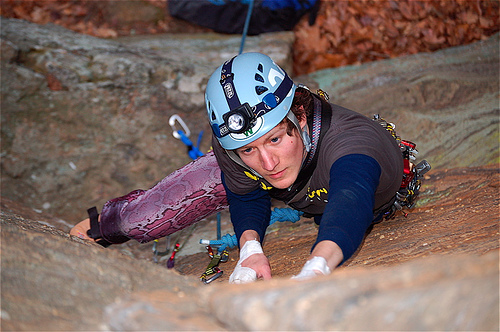

In [27]:
from PIL import Image
img = Image.open('C:/Users/info/Downloads/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg')
img

In [28]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

1/1 [==============================] - 10s 10s/step



start man is climbing up the side of cliff end


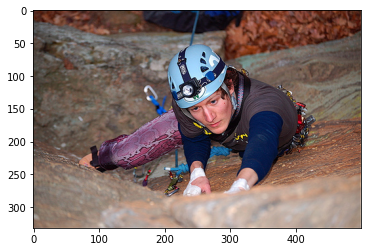

In [9]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


img_path = 'C:/Users/info/Downloads/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)


1/1 [==============================] - 0s 50ms/step



start man in red shirt is climbing rock end


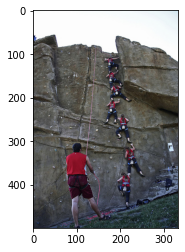

In [ ]:
img_path3 = "C:/Users/info/Downloads/Flickr8k_Dataset/Flicker8k_Dataset/111537222_07e56d5a30.jpg"
photo = extract_features(img_path3, xception_model)
img = Image.open(img_path3)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)


In [ ]:
from keras.applications.xception import Xception

img_path3 = 'C:/Users/info/Downloads/Flickr8k_Dataset/Flicker8k_Dataset/2511019188_ca71775f2d.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path3, xception_model)
img = Image.open(img_path3)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

## Evaluation : Bleu Score

Bleu score stands for Bilingual evaluation understudy score , basically summarizes how close a particular generated text is to the expected text 
if a machine generated caption close to a reference or actual caption then the blue score will be high or close to 1 . If there is a mismatch the score will be close to 0 . 

*Bleu Score* : help us in measuring how good a particular machine-generated caption is by automatically computing a score

![title](pic2.jpeg)

- nltk : provides in fact a function called *corpus_bleu* which can evaluate a sentence in question with one or more reference list of tokens 

In [10]:
# evaluate the skill of the model
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

We print four different BLEU scores:

- BLEU-1 focuses on individual word matches.
- BLEU-2 looks at pairs of words.
- BLEU-3 evaluates triplets of words.
- BLEU-4 considers sequences of four words.

In [11]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

- The script begins by loading the test set of photo identifiers from a specified file.
- It then prints the number of photos in the test set.

In [21]:
filename = 'C:/Users/info/Downloads/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_photos(filename)
print('Dataset: %d' % len(test))
# evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000


In [22]:
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


After loading the test set, the script proceeds to load descriptions and features for the test images.

In [23]:
test_features = load_features(test)
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [24]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.354894
BLEU-2: 0.190975
BLEU-3: 0.130346
BLEU-4: 0.053190


The BLEU scores *decrease significantly as n-gram length increases*. This indicates that while the model can produce relevant individual words, it struggles with generating accurate and fluent longer sequences (bigrams, trigrams, and 4-grams).